# Running Deep learning models with BioEngine

This tutorial covers 3 models:
 * Inception model for single cell protein localization classification (by Bestfitting in the HPA single cell classification competition 2021)
 * CellPose (C Stringer et. al 2021)
 * Stardist (Weigert et. al 2020
 
Note: Please be aware that the data will be sent to a remote server (https://ai.imjoy.io/triton) running by the ImJoy team, the service is for evaluation purpose only and it is subject to change without notice. In the near future we will release the deployment toolkit so you can also run your own server easily.

In [5]:
# If you are running your own jupyter notebook
# Skip the first two lines and do `pip install pyotritonclient` instead
import micropip
await micropip.install('pyotritonclient')

from js import fetch
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyotritonclient import execute

LABELS = {
  0: 'Nucleoplasm',
  1: 'Nuclear membrane',
  2: 'Nucleoli',
  3: 'Nucleoli fibrillar center',
  4: 'Nuclear speckles',
  5: 'Nuclear bodies',
  6: 'Endoplasmic reticulum',
  7: 'Golgi apparatus',
  8: 'Intermediate filaments',
  9: 'Actin filaments',
  10: 'Microtubules',
  11: 'Mitotic spindle',
  12: 'Centrosome',
  13: 'Plasma membrane',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'Vesicles and punctate cytosolic patterns',
  18: 'Negative',
}

COLORS =  ["red", "green", "blue", "yellow"]

async def fetch_image(url, name=None, grayscale=False, size=None):
    response = await fetch(url)
    bytes = await response.arrayBuffer()
    bytes = bytes.to_py()
    buffer = io.BytesIO(bytes)
    buffer.name = name or url.split('?')[0].split('/')[1]
    image = Image.open(buffer)
    if grayscale:
        image = image.convert('L')
    if size:
        image = image.resize(size=size)
    image = np.array(image)
    return image

async def fetch_hpa_image(image_id):
    crops = []
    for color in COLORS:
        image = await fetch_image(f'https://images.proteinatlas.org/{image_id}_{color}.jpg', grayscale=True, size=(340, 340))
        crops.append(image)
    image = np.stack(crops, axis=0)
    # assert image.shape == (4, 128, 128)
    return image

# Fetch an image from HPA website by its ID

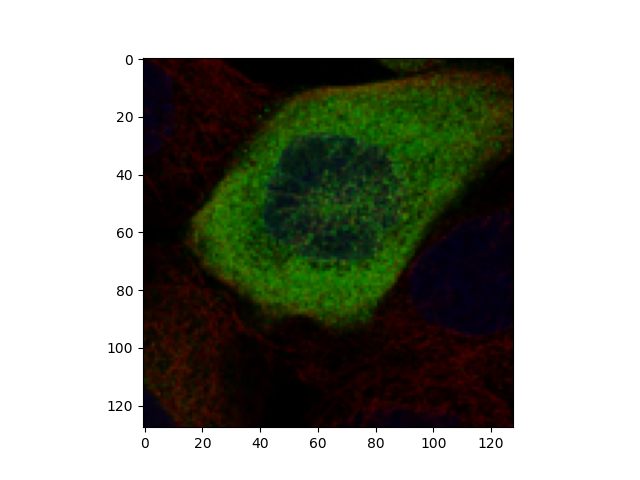

In [6]:
image = await fetch_hpa_image('115/672_E2_1')
# crop the image to a single cell
image = image[:, 60:188, 120:248]

# make sure the image size is 128x128
assert image.shape == (4, 128, 128), "please make sure the image size is 128x128"
# display the image
plt.imshow(image.transpose(1,2,0)[:,:,:3])
plt.show()

# Run the classification model to make prediction

In [7]:
results = await execute([image.astype('float32')/255],
                        server_url='https://ai.imjoy.io/triton',
                        model_name='bestfitting-inceptionv3-single-cell')
classes = results['classes']
pred = [(LABELS[i], prob) for i, prob in enumerate(classes.tolist()) if prob>0.5]

print(f'Prediction: {pred}')

Prediction: [('Cytosol', 0.7802549004554749)]


# Run CellPose for cell segmentation

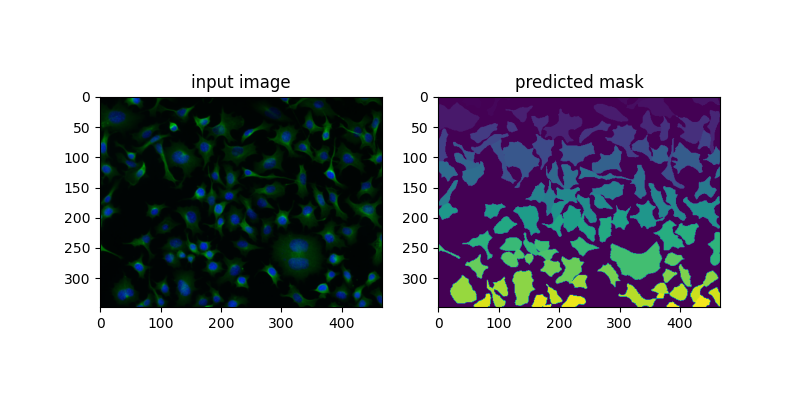

In [9]:
image = await fetch_image('https://static.imjoy.io/img/img02.png')
image = image.astype('float32')
param = {'diameter': 30, 'model_type': 'cyto'}

# run inference
results = await execute([image.transpose(2, 0, 1), param],
                              server_url='https://ai.imjoy.io/triton',
                              model_name='cellpose-python',
                              decode_bytes=True)
mask = results['mask']

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.astype('uint8'))
ax1.set_title('input image')
ax2.imshow(mask[0])
ax2.set_title('predicted mask')
plt.show()

# Run Stardist for nuclei segmentation

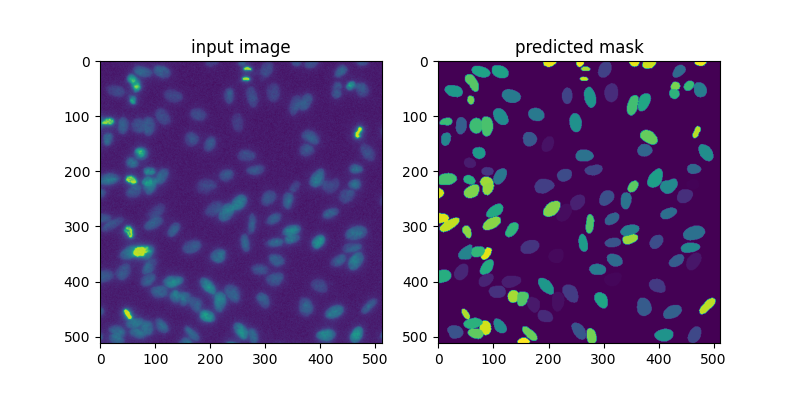

In [11]:
# obtain the model config
image = await fetch_image('https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif', grayscale=True)
image = image.astype('uint16')
diameter = {'diameter': 30}

# run inference
results = await execute_model([image, diameter],
                              server_url='https://ai.imjoy.io/triton',
                              model_name='stardist',
                              decode_bytes=True)
mask = results['mask']

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title('input image')
ax2.imshow(mask)
ax2.set_title('predicted mask')
plt.show()